In [96]:
import torch
import torchvision
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from typing import List, Tuple
import numpy as np
import torch
import torchvision
from torch import nn
from torch.nn.functional import cross_entropy
from torch.optim import SGD
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor, Lambda, Normalize
from torch.utils.data import DataLoader
from torchvision import transforms

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [97]:
batch_size_train = 60
batch_size_test = 1000
learning_rate = 0.01
momentum = 0.5
log_interval = 10
repeat = 10
random_seed = 1
n_epochs = 100

In [98]:
class Add_Noise(object):
  def __init__(self, boundary=0, p=0.1):
    self.boundary = boundary
    self.p = p

  def __call__(self, sample):
    image = sample

    for i, layer in enumerate(image):
      for j, pixel in enumerate(layer):
        if pixel > self.boundary:
          if np.random.uniform(0, 1) > self.p:
            image[i][j] = -0.4242

    return image

In [99]:
from torch.utils.data import Dataset, DataLoader

mnist_train = MNIST('/files/', train=True, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ]))


sub = list(range(0, len(mnist_train), 10))
mnist_train = torch.utils.data.Subset(mnist_train, sub)

mnist_test = MNIST('/files/', train=False, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ]))

sub = list(range(0, len(mnist_test), 10))
mnist_test = torch.utils.data.Subset(mnist_test, sub)

In [100]:
class MNIST_With_RepeatAndNoise(Dataset):
    def __init__(self, mnist_dataset, repeat_factor=5, noise_transform=None):
        self.mnist_dataset = mnist_dataset
        self.repeat_factor = repeat_factor
        self.noise_transform = noise_transform

    def __len__(self):
        return len(self.mnist_dataset) * self.repeat_factor

    def __getitem__(self, idx):
        idx //= self.repeat_factor
        x, y = self.mnist_dataset[idx]
        y = torch.tensor(y)

        x = x.repeat(self.repeat_factor, 1, 1)
        y = y.repeat(self.repeat_factor)

        for i in range(self.repeat_factor):
          x[i] = self.noise_transform(x[i])

        return x, y

train_dataset = MNIST_With_RepeatAndNoise(mnist_train, repeat_factor=repeat, noise_transform=Add_Noise())
test_dataset = MNIST_With_RepeatAndNoise(mnist_test, repeat_factor=repeat, noise_transform=Add_Noise())


In [9]:
from google.colab import files
uploaded = files.upload()

Saving train_data_0.1_rep10.pt to train_data_0.1_rep10.pt


In [101]:
from torch.utils.data import Dataset, DataLoader

class CustomDataset(Dataset):
    def __init__(self, data_path, targets_path):
        self.data = torch.load(data_path)
        self.targets = torch.load(targets_path)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        x = self.data[idx]
        y = self.targets[idx]

        return x, y

train_data_path = "train_data_0.1_rep10.pt"
train_targets_path = "train_targets_0.1_rep10.pt"
test_data_path = "test_data_0.1_rep10.pt"
test_targets_path = "test_targets_0.1_rep10.pt"

train_dataset = CustomDataset(train_data_path, train_targets_path)
test_dataset = CustomDataset(test_data_path, test_targets_path)

train_loader_new = DataLoader(train_dataset, batch_size=60, shuffle=True)
test_loader_new = DataLoader(test_dataset, batch_size=10, shuffle=False)

<Figure size 640x480 with 0 Axes>

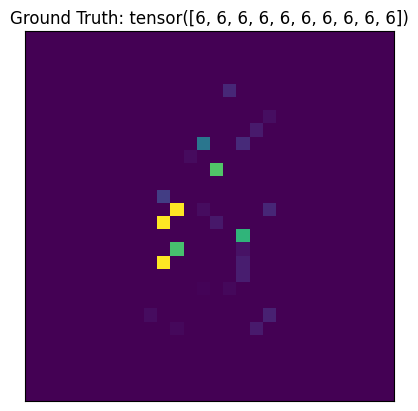

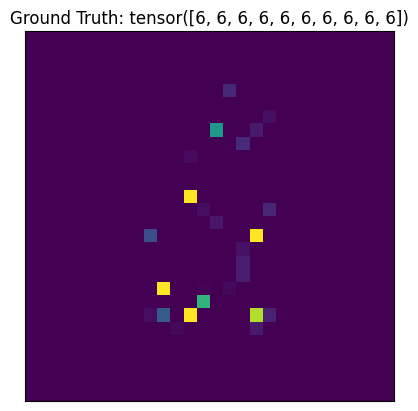

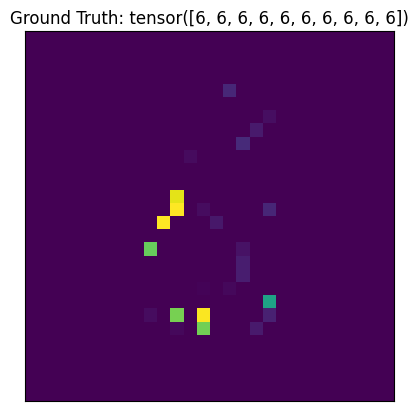

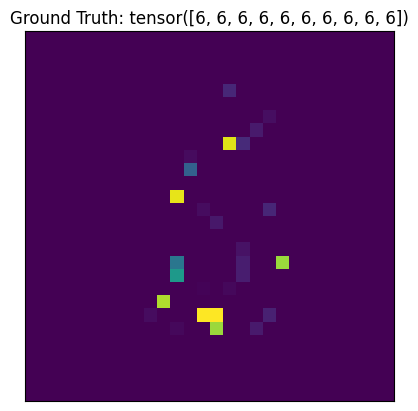

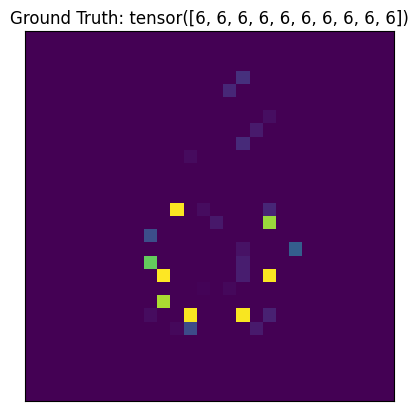

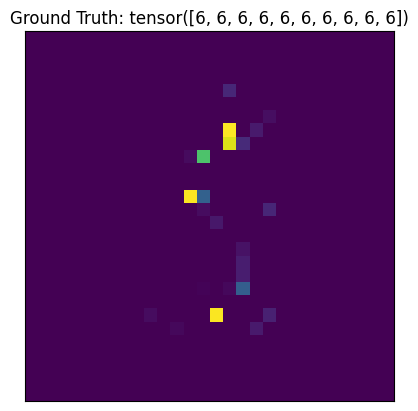

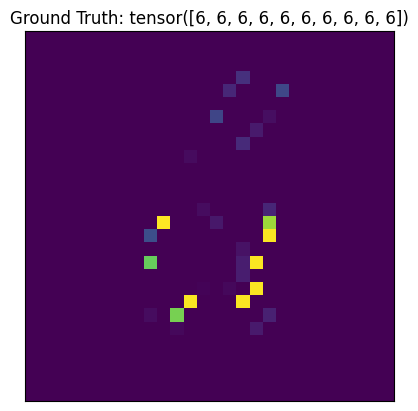

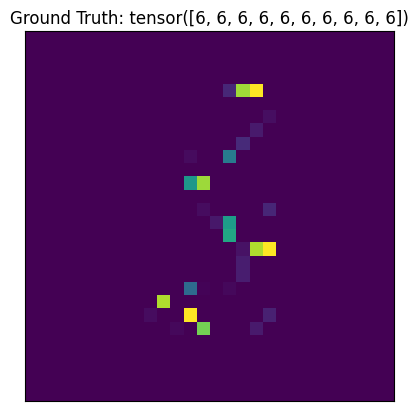

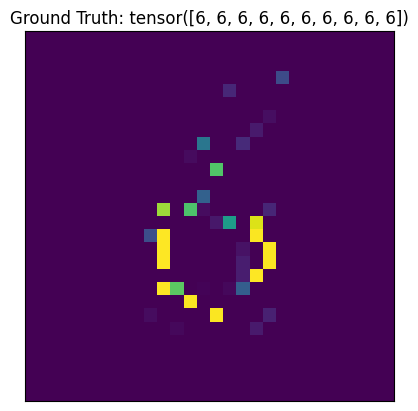

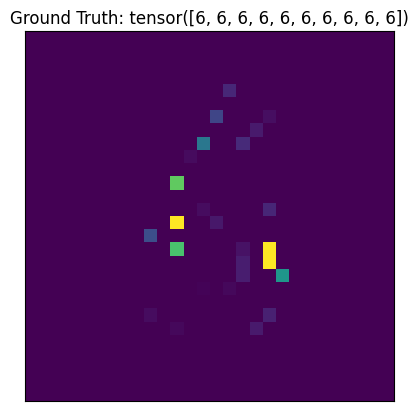

In [102]:
examples = enumerate(test_loader_new)
batch_idx, (example_data, example_targets) = next(examples)

import numpy as np
import matplotlib.pyplot as plt

fig = plt.figure()
for i in range(repeat):
  fig = plt.figure()
  plt.tight_layout()
  plt.imshow(example_data[0, i, :, :], interpolation='none')
  plt.title("Ground Truth: {}".format(example_targets[0]))
  plt.xticks([])
  plt.yticks([])

In [103]:
class Net_hidden(nn.Module):
    def __init__(self):
        super(Net_hidden, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(100, 10)
        self.batch = 60
        self.hidden = torch.zeros([self.batch, 50]).to(device)

    def zero_hidden(self):
        self.hidden = torch.zeros([self.batch, 50]).to(device)

    def update_hidden(self, x):
        self.hidden = x.to(device)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        new_hidden = F.dropout(x, training=self.training)
        x = torch.cat((new_hidden, self.hidden), 1)

        x = self.fc2(x)
        return F.log_softmax(x), new_hidden

In [104]:
network = Net_hidden().to(device)
optimizer = optim.SGD(network.parameters(), lr=learning_rate)
train_losses = []
train_counter = []
test_losses = []
test_counter = [i*len(train_loader_new.dataset) for i in range(n_epochs + 1)]

In [107]:
def train_hidden(epoch):
  network.batch = 60
  network.zero_hidden()
  network.train()
  for batch_idx, (data, target) in enumerate(train_loader_new):
    data, target = data.to(device), target.to(device)
    network.zero_hidden()
    for r in range(repeat):
      optimizer.zero_grad()
      output, hidden = network(data[:, r, :, :].unsqueeze(1))
      loss = F.nll_loss(output, target[:, r])
      loss.backward()
      optimizer.step()
      hidden = hidden.detach()
      network.update_hidden(hidden)
    if batch_idx % log_interval == 0:
      print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
        epoch, batch_idx * len(data), len(train_loader_new.dataset),
        100. * batch_idx / len(train_loader_new), loss.item()))
      train_losses.append(loss.item())
      train_counter.append(
        (batch_idx*60) + ((epoch-1)*len(train_loader_new.dataset)))

def test_hidden():
  network.batch = 10
  network.zero_hidden()
  network.eval()
  test_loss = 0
  correct = 0
  with torch.no_grad():
    for data, target in test_loader_new:
      data, target = data.to(device), target.to(device)
      network.zero_hidden()
      for r in range(repeat):
        output, hidden = network(data[:, r, :, :].unsqueeze(1))
        test_loss += F.nll_loss(output, target[:, r], size_average=False).item()
        network.update_hidden(hidden)
      pred = output.data.max(1, keepdim=True)[1]
      correct += pred.eq(target[:, 0].unsqueeze(1).data.view_as(pred)).sum()
  test_loss /= len(test_loader_new.dataset)
  test_losses.append(test_loss)
  print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
    test_loss, correct, len(test_loader_new.dataset),
    100. * correct / len(test_loader_new.dataset)))

In [108]:
for epoch in range(1, n_epochs + 1): #n_epochs=100
  train_hidden(epoch)
  test_hidden()

<ipython-input-103-8dfb2fdbc020>:27: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x), new_hidden


Train Epoch: 1 [0/6000 (0%)]	Loss: 2.225034
Train Epoch: 1 [600/6000 (10%)]	Loss: 2.196599
Train Epoch: 1 [1200/6000 (20%)]	Loss: 2.141846
Train Epoch: 1 [1800/6000 (30%)]	Loss: 2.032293
Train Epoch: 1 [2400/6000 (40%)]	Loss: 1.925366
Train Epoch: 1 [3000/6000 (50%)]	Loss: 1.628869
Train Epoch: 1 [3600/6000 (60%)]	Loss: 1.571167
Train Epoch: 1 [4200/6000 (70%)]	Loss: 1.431914
Train Epoch: 1 [4800/6000 (80%)]	Loss: 1.699723
Train Epoch: 1 [5400/6000 (90%)]	Loss: 1.602069

Test set: Avg. loss: 12.8992, Accuracy: 616/1000 (62%)

Train Epoch: 2 [0/6000 (0%)]	Loss: 1.542581
Train Epoch: 2 [600/6000 (10%)]	Loss: 1.390221
Train Epoch: 2 [1200/6000 (20%)]	Loss: 1.143661
Train Epoch: 2 [1800/6000 (30%)]	Loss: 1.331879
Train Epoch: 2 [2400/6000 (40%)]	Loss: 1.274500
Train Epoch: 2 [3000/6000 (50%)]	Loss: 1.474658
Train Epoch: 2 [3600/6000 (60%)]	Loss: 1.418194
Train Epoch: 2 [4200/6000 (70%)]	Loss: 1.345828
Train Epoch: 2 [4800/6000 (80%)]	Loss: 1.182344
Train Epoch: 2 [5400/6000 (90%)]	Loss: 0.